In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
# Mount colab to files in Google Drive
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/NHANES_2021_2023/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
demo = pd.read_sas(path + 'DEMO_L.xpt')
vid = pd.read_sas(path + 'VID_L.xpt')
hep = pd.read_sas(path + 'HEPB_S_L.xpt')
bp = pd.read_sas(path + 'BPXO_L.xpt')
pa = pd.read_sas(path + 'PAQ_L.xpt')
kid = pd.read_sas(path + 'KIQ_U_L.xpt')
wh = pd.read_sas(path + 'WHQ_L.xpt')

In [ ]:
# Merge all on SEQN
dfs = [demo, vid, hep, bp, pa, kid, wh]
data =dfs[0]
for d in dfs[1:]:
  data = data.merge(d, on='SEQN', how ='left')

  data.shape
  data.head()

In [ ]:
data.shape
data.head()

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,KIQ005,KIQ010,KIQ042,KIQ044,KIQ052,KIQ481,WHD010,WHD020,WHD050,WHQ070
0,130378.0,12.0,2.0,1.0,43.0,NaN,5.0,6.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,71.0,190.0,200.0,1.0
1,130379.0,12.0,2.0,1.0,66.0,NaN,3.0,3.0,2.0,NaN,...,2.0,2.0,1.0,2.0,2.0,2.0,70.0,220.0,220.0,2.0
2,130380.0,12.0,2.0,2.0,44.0,NaN,2.0,2.0,1.0,NaN,...,1.0,NaN,2.0,2.0,NaN,2.0,60.0,150.0,165.0,1.0
3,130381.0,12.0,2.0,2.0,5.0,NaN,5.0,7.0,1.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,130382.0,12.0,2.0,1.0,2.0,NaN,3.0,3.0,2.0,34.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# CLEAN UP
# --- Recode marital status ---
# DMDMARTZ: 1 = Married, 6 = Living with partner → Married/Partnered
# 2, 3, 4, 5 = Not married
def recode_marital(x):
    if x in [1, 6]:
        return "Married/Partnered"
    elif x in [2, 3, 4, 5]:
        return "Not married"
    else:
        return np.nan

data['married'] = data['DMDMARTZ'].apply(recode_marital)

# --- Recode education ---
# DMDEDUC2: 5 = College graduate or above → Bachelor+
# 1–4 = <Bachelor
def recode_edu(x):
    if x == 5:
        return "Bachelor+"
    elif x in [1, 2, 3, 4]:
        return "<Bachelor"
    else:
        return np.nan

data['edu_level'] = data['DMDEDUC2'].apply(recode_edu)

# --- Continuous variables ---
# Rename and clean values (remove 7777, 9999)
data['sedentary_min'] = data['PAD680'].replace([7777, 9999], np.nan)
data['weight_self'] = data['WHD020'].replace([7777, 9999], np.nan)
data['age'] = data['RIDAGEYR']
data['sys_bp'] = data['BPXOSY3']
data['dia_bp'] = data['BPXODI3']

# --- Other categorical variables ---
data['vitd_status'] = data['LBDVD2LC']  # already categorical
data['hepb_status'] = np.where(data['LBXHBS'] > 0, "Positive", "Negative")
data['kidney_status'] = np.where(data['KIQ022'] == 1, "Weak/Failing", "No issue")

# --- Keep only relevant columns for analysis ---
analysis_df = data[['SEQN','married','edu_level','age','sys_bp','dia_bp',
                    'vitd_status','hepb_status','kidney_status',
                    'sedentary_min','weight_self']].copy()

# --- Quick checks ---
print("✅ Data cleaned ")
print("Rows, Columns:", analysis_df.shape)

✅ Data cleaned 
Rows, Columns: (11933, 11)


In [ ]:
# --- Question 1: Association between marital status and education ---
q1 = analysis_df.dropna(subset=['married', 'edu_level'])

# Contingency table
ct_q1 = pd.crosstab(q1['married'], q1['edu_level'])
print("Contingency Table:")
print(ct_q1)

# Chi-square test
chi2, p, dof, expected = stats.chi2_contingency(ct_q1)

print("\nChi-square test results:")
print("Chi-square:", chi2)
print("Degrees of Freedom:", dof)
print("p-value:", p)

Contingency Table:
edu_level          <Bachelor  Bachelor+
married                                
Married/Partnered       2503       1631
Not married             2648        990

Chi-square test results:
Chi-square: 129.17381826322236
Degrees of Freedom: 1
p-value: 6.213197986632679e-30


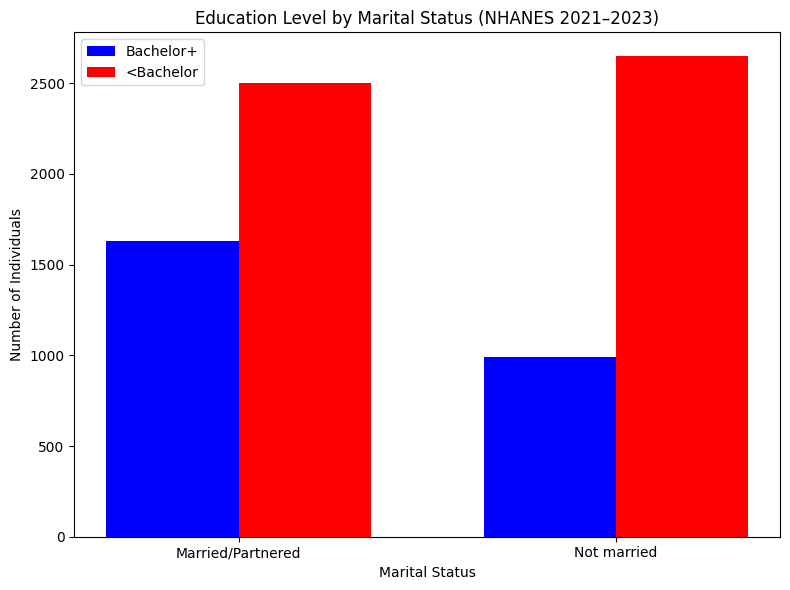

In [ ]:
# Use the same contingency table from Q1
contingency_table = pd.crosstab(q1['married'], q1['edu_level'])

# Extract categories and counts
categories = contingency_table.index.tolist()
bachelor_counts = contingency_table['Bachelor+'].tolist()
less_bachelor_counts = contingency_table['<Bachelor'].tolist()

# Set up positions for the bars
x = np.arange(len(categories))
width = 0.35

# Create the grouped bar chart
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x - width/2, bachelor_counts, width, label='Bachelor+', color='blue')
ax.bar(x + width/2, less_bachelor_counts, width, label='<Bachelor', color='red')

# Label axes and title
ax.set_xlabel('Marital Status')
ax.set_ylabel('Number of Individuals')
ax.set_title('Education Level by Marital Status (NHANES 2021–2023)')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
q2 = analysis_df.dropna(subset=['married', 'sedentary_min'])

#separate the two groups
married_group = q2[q2['married']== 'Married/Partnered']['sedentary_min']
not_married_group = q2[q2['married']== 'Not married']['sedentary_min']

# Run an independent samples t-test (Welch’s version, unequal variances)
from scipy import stats
t_stat, p_val = stats.ttest_ind(married_group, not_married_group, equal_var=False)

print("Mean sedentary (Married/Partnered):", round(married_group.mean(), 2))
print("Mean sedentary (Not married):", round(not_married_group.mean(), 2))
print("t-statistic:", round(t_stat, 3))
print("p-value:", p_val)

Mean sedentary (Married/Partnered): 353.29
Mean sedentary (Not married): 371.96
t-statistic: -3.851
p-value: 0.0001184387220986923


/tmp/ipython-input-3223864168.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=q2, x='married', y='sedentary_min', palette=['skyblue','salmon'])


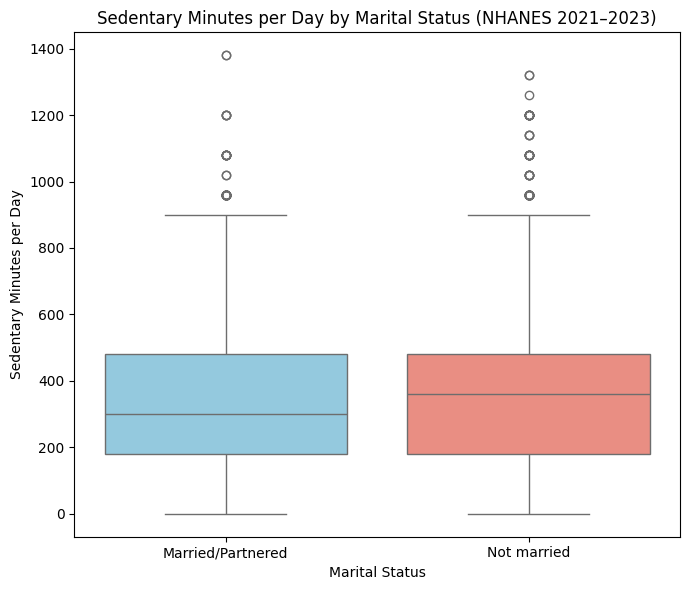

In [ ]:
plt.figure(figsize=(7,6))
sns.boxplot(data=q2, x='married', y='sedentary_min', palette=['skyblue','salmon'])
plt.title('Sedentary Minutes per Day by Marital Status (NHANES 2021–2023)')
plt.xlabel('Marital Status')
plt.ylabel('Sedentary Minutes per Day')
plt.tight_layout()
plt.show()

In [ ]:
# Drop missing values
q3 = analysis_df.dropna(subset=['sys_bp', 'age', 'married'])

# Run multiple linear regression
model_q3 = smf.ols('sys_bp ~ age + C(married)', data=q3).fit()

# Print summary
print(model_q3.summary())

                            OLS Regression Results                            
Dep. Variable:                 sys_bp   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     453.3
Date:                Fri, 07 Nov 2025   Prob (F-statistic):          1.00e-183
Time:                        03:45:13   Log-Likelihood:                -24856.
No. Observations:                5838   AIC:                         4.972e+04
Df Residuals:                    5835   BIC:                         4.974e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

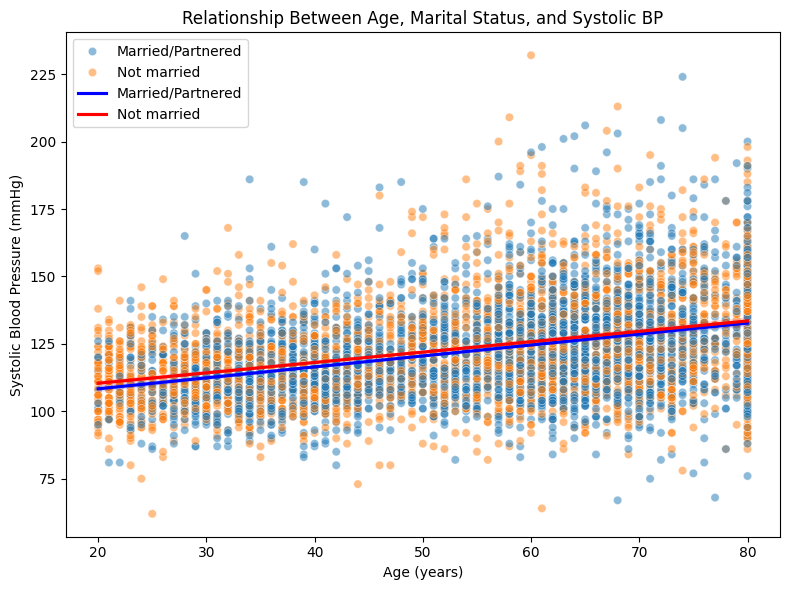

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=q3, x='age', y='sys_bp', hue='married', alpha=0.5)
sns.regplot(data=q3[q3['married']=="Married/Partnered"], x='age', y='sys_bp', scatter=False, color='blue', label='Married/Partnered')
sns.regplot(data=q3[q3['married']=="Not married"], x='age', y='sys_bp', scatter=False, color='red', label='Not married')

plt.title('Relationship Between Age, Marital Status, and Systolic BP')
plt.xlabel('Age (years)')
plt.ylabel('Systolic Blood Pressure (mmHg)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Drop missing values
q4 = analysis_df.dropna(subset=['weight_self', 'sedentary_min'])

# Compute Pearson correlation
r, p = stats.pearsonr(q4['weight_self'], q4['sedentary_min'])

print("Correlation coefficient (r):", round(r, 3))
print("p-value:", p)

Correlation coefficient (r): 0.156
p-value: 1.6988498386823033e-44


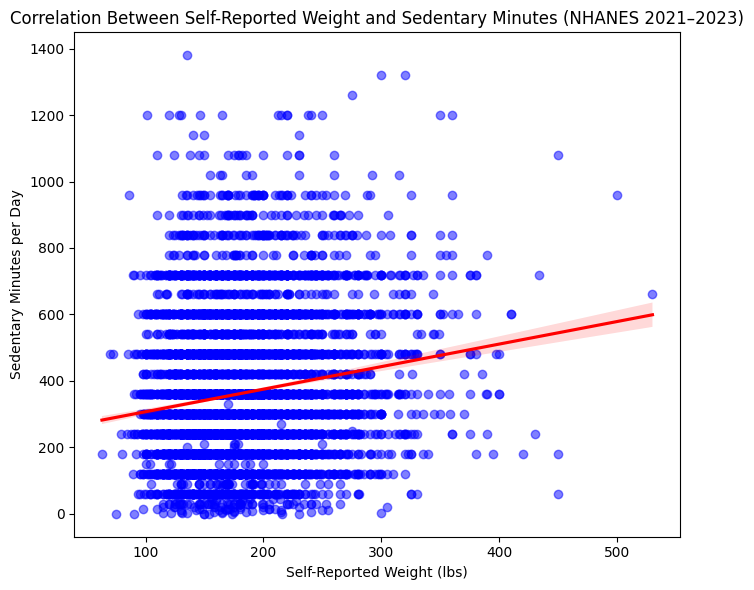

In [ ]:
plt.figure(figsize=(7,6))
sns.regplot(
    data=q4,
    x='weight_self',
    y='sedentary_min',
    scatter_kws={'alpha':0.5, 'color':'blue'},
    line_kws={'color':'red'}
)
plt.title('Correlation Between Self-Reported Weight and Sedentary Minutes (NHANES 2021–2023)')
plt.xlabel('Self-Reported Weight (lbs)')
plt.ylabel('Sedentary Minutes per Day')
plt.tight_layout()
plt.show()

In [ ]:
# Drop missing values
q5 = analysis_df.dropna(subset=['kidney_status', 'sys_bp'])

# Separate the 2 groups
weak = q5[q5['kidney_status'] == 'Weak/Failing']['sys_bp']
healthy = q5[q5['kidney_status'] == 'No issue']['sys_bp']

# Run independent samples t-test
t_stat, p_val = stats.ttest_ind(weak, healthy, equal_var=False)

print("Mean systolic BP (Weak/Failing kidneys):", round(weak.mean(), 2))
print("Mean systolic BP (NO kidney issue):", round(healthy.mean(), 2))
print("t-statistic:", round(t_stat, 3))
print("p-value:", p_val)

Mean systolic BP (Weak/Failing kidneys): 126.9
Mean systolic BP (NO kidney issue): 118.67
t-statistic: 5.289
p-value: 2.8774694175486966e-07


/tmp/ipython-input-535335335.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=q5, x='kidney_status', y='sys_bp', palette=['lightcoral','skyblue'])


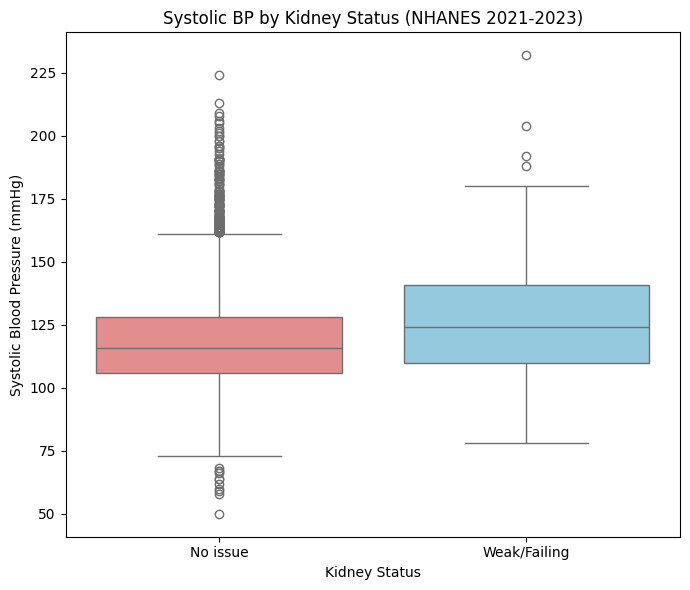

In [ ]:
plt.figure(figsize=(7,6))
sns.boxplot(data=q5, x='kidney_status', y='sys_bp', palette=['lightcoral','skyblue'])
plt.title('Systolic BP by Kidney Status (NHANES 2021-2023)')
plt.xlabel('Kidney Status')
plt.ylabel('Systolic Blood Pressure (mmHg)')
plt.tight_layout()
plt.show()